In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter

from gpflow.likelihoods import Gaussian

from markovflow.models import SparseVariationalGaussianProcess
from markovflow.kernels import Matern12, Matern32
from markovflow.kernels.sde_kernel import IndependentMultiOutputStack
from markovflow.ssm_natgrad import SSMNaturalGradient

2022-09-17 15:54:16.567297: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-09-17 15:54:16.567334: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Stacked kernels and multiple outputs
This notebook is about _stacked kernels_, which is one way to get multiple outputs in MarkovFlow. 

Stacked kernels use a leading 'batch' dimension to compute multiple kernels together. Conceptually, if a kernel matrix is of dimensions `[N x N]`, then a stacked kernel produces an object of shape `[S x N x N]`. All of the markovflow computations will have this extra leading dimension. For example the state-transition matrices will be of shape `[S, T, D, D]`, where T is the number of time points and D is the state dimension. 

The _data_, however, are expected to be of shape `[N x S]`, so the `S` dimension should follow, not lead. This convention makes the stacked kernel compatible with likelihoods that can handle multiple outputs and processes. 

The advantage of this approach to multiple-outputs is that it is computationally efficient, because all computations can loop over this leading `S` dimension instead of augmenting the state dimension of the process. However, using a similar parameterization as an approximate posterior in an inference problem is a bit restrictive since it forces the posterior processes to be independent which may not always be an appropriate assumption.
 
You may also be interesed in another style of multiple output kernels in MarkovFlow, where the state-dimensions of the processes are concatenated. In that case, the computational complexity grows cubically with the number of outputs, since the state dimension is growing. See the factor_analysis notebook.

## A simple example

We'll build a model with two outputs using a stacked kernel. We use the sparse GP object from markovflow to do inference.

In [2]:
# constants
num_data = 300
num_inducing = 50
num_outputs = 2
lengthscales = [0.05, 0.05]

In [3]:
# construct a simple data set with correlated noise
X = np.linspace(0, 1, num_data)
X_tf = tf.broadcast_to(X, (num_outputs, num_data)) # duplicate
F = np.hstack([np.sin(10 * X)[:, None], np.cos(15 * X)[:, None]])
Sigma = np.array([[0.1, 0.08], [0.08, 0.1]])
noise = np.random.multivariate_normal(np.zeros(2), Sigma, num_data)
Y = F + noise
data = (X_tf, tf.convert_to_tensor(Y))

2022-09-17 15:54:18.232026: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-17 15:54:18.232198: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-09-17 15:54:18.232209: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-17 15:54:18.232232: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az178-774): /proc/driver/nvidia/version does not exist
2022-09-17 15:54:18.232476: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F F

In [4]:
# constuct a stacked kernel with two outputs
k1 = Matern12(lengthscale=lengthscales[0], variance=1.)
k2 = Matern32(lengthscale=lengthscales[1], variance=1.)
kern = IndependentMultiOutputStack([k1, k2], jitter=1e-6)

# construct a model
lik = Gaussian(1.)
Z = tf.broadcast_to(np.linspace(0, 1, num_inducing), (num_outputs, num_inducing))
m = SparseVariationalGaussianProcess(kern, lik, Z)

Instructions for updating:
Do not call `graph_parents`.


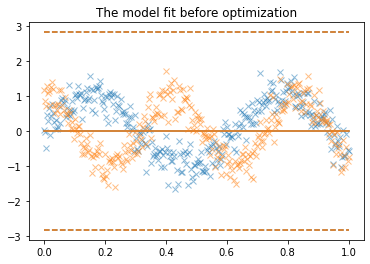

In [5]:
def plot():
    # plot the data with predictions:
    p = m.posterior
    mu, var = p.predict_y(X_tf)
    for i in [0, 1]:
        plt.plot(X, Y[:, i], f'C{i}x', alpha=0.5)
        plt.plot(X, mu[:, i], f'C{i}')
        std = tf.math.sqrt(var[:, i])
        plt.plot(X, mu[:, i] + 2 * std, f'C{i}--')
        plt.plot(X, mu[:, i] - 2 * std, f'C{i}--')

plot()
_ = plt.title('The model fit before optimization')

In [6]:
def optimize(model):
    # we'll use the natural gradient optimizer for the variational parameters and the Adam optimizer for hyper-parameters
    opt_ng = SSMNaturalGradient(.5)
    opt_adam = tf.optimizers.Adam(0.05)

    @tf.function
    def step():
        opt_adam.minimize(lambda : -model.elbo(data), model._likelihood.trainable_variables + model._kernel.trainable_variables)
        opt_ng.minimize(lambda : -model.elbo(data), ssm=m.dist_q)
    
    @tf.function
    def elbo():
        return m.elbo(data)
    
    max_iter = ci_niter(400)
    for i in range(max_iter):
        step()
        if i % 50 == 0:
            print(f"Iteration {i}, elbo:{elbo().numpy():.4}")

In [7]:
optimize(m)

2022-09-17 15:54:19.280732: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Use fn_output_signature instead


2022-09-17 15:54:35.257400: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-17 15:54:35.257856: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793435000 Hz


2022-09-17 15:54:50.812413: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9


2022-09-17 15:54:57.164086: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_equal_59/Assert/AssertGuard/branch_executed/_94


Iteration 0, elbo:-994.6


Iteration 50, elbo:-522.1


Iteration 100, elbo:-311.5


Iteration 150, elbo:-253.8


Iteration 200, elbo:-239.8


Iteration 250, elbo:-235.0


Iteration 300, elbo:-231.9


Iteration 350, elbo:-229.1


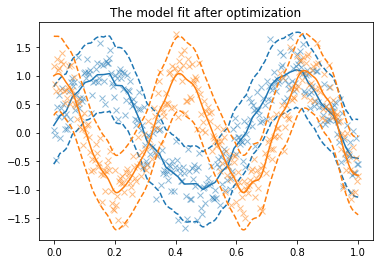

In [8]:
plot()
_ = plt.title('The model fit after optimization')

## What about broadcasting?
Since we're using a leading dimension in the stacked kernel, we might be worried about whether this impedes markovflow's ability to fit a model to multiple independent datasets. Fear not! extra leading dimensions are still handled (and looped over appropriately), and parameter sharing of the kernels (between datasets, not outputs) still happens smoothly. 

In this example, we'll fit a model with a heteroskedastic likelihood to multiple datasets simultaneously. The likelihood requires two GP outputs to model a *single* data column. One of the GPs models the mean of the data, and the other models the variance. We'll generate multiple datasets, construct the outline of a very simple likelihood and fit the whole shebang in a single markovflow model. Each dataset gets its own GPs, but the kernels paraemters are shared amongst datasets. 

In [9]:
num_data = 300
num_datasets = 2
num_inducing = 30
num_gp_outputs = 2
num_data_outputs = 1
lengthscales = [0.05, 0.5]

In [10]:
# generate datasets from sinusoidal means and time varying noise variances (exponentiated sinusoids)
Xs, Ys = [], []
for d in range(num_datasets):
    X = np.linspace(0, 1, num_data)
    amplitudes = np.random.rand(2) * np.array([1, 0.5]) + np.array([3, 2])
    phases = np.random.randn(2) * 2 * np.pi
    frequencies =  np.array([10, 2])
    f1, f2 = [np.sin(2*np.pi * X * omega + phi) * a for omega, phi, a in zip(frequencies, phases, amplitudes)]
    Y = f1 + np.random.randn(*f2.shape) * np.exp(0.5 * f2)
    Ys.append(Y.reshape(num_data, num_data_outputs))
    Xs.append(tf.broadcast_to(X, (num_gp_outputs, num_data)))

Xs = tf.convert_to_tensor(Xs)  # [num_datasets, num_gps, num_data]
Ys = tf.convert_to_tensor(Ys)  # [num_datasets, num_data, num_data_outputs]
data = (Xs, Ys)

In [11]:
from markovflow.likelihoods import Likelihood
import tensorflow_probability as tfp

class HetGaussian(Likelihood):
    def log_probability_density(self, f, y):
        mu, logvar = f[..., 0], f[..., 1]
        return tfp.distributions.Normal(loc=mu, scale=tf.exp(0.5 * logvar)).log_p(y[..., 0])
    
    def variational_expectations(self, f_means, f_covariances, observations):
        f1, f2 = f_means[..., 0], f_means[..., 1]
        variances = f_covariances # assume independent GPs
        v1, v2 = variances[..., 0], variances[..., 1]
        return -0.5 * (np.log(2*np.pi) + f2 + 
                       tf.exp(-f2 + 0.5 * v2) * (tf.square(f1 - observations[..., 0]) + v1))
    def predict_density(self, f_means, f_covariances, observations):
        raise NotImplementedError

    def predict_mean_and_var(self, f_means, f_covariances):
        raise NotImplementedError

In [12]:
# constuct a stacked kernel with two outputs
k1 = Matern32(lengthscale=.05, variance=1.)
k2 = Matern12(lengthscale=.5, variance=1.)
kern = IndependentMultiOutputStack([k1, k2])

# construct a model
lik = HetGaussian()
Z = tf.broadcast_to(np.linspace(0, 1, num_inducing), (num_datasets, num_gp_outputs, num_inducing))
m = SparseVariationalGaussianProcess(kern, lik, Z)

print(m.elbo(data))

tf.Tensor(-5570.847114316649, shape=(), dtype=float64)


In [13]:
from gpflow.optimizers import Scipy
opt = Scipy()
opt.minimize(lambda: -m.elbo(data), m.trainable_variables, options=dict(maxiter=ci_niter(1000)))

2022-09-17 15:55:10.079404: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9


      fun: 1290.3436786177656
 hess_inv: <1068x1068 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.42880514, -0.94413704,  0.89699324, ..., -1.10693675,
       -0.36922019,  0.29900939])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 1049
      nit: 1000
     njev: 1049
   status: 1
  success: False
        x: array([-1.43898835e-01, -1.33500294e-03, -1.31227604e+01, ...,
        8.95741743e+00,  1.46095999e+00,  6.95882747e+00])

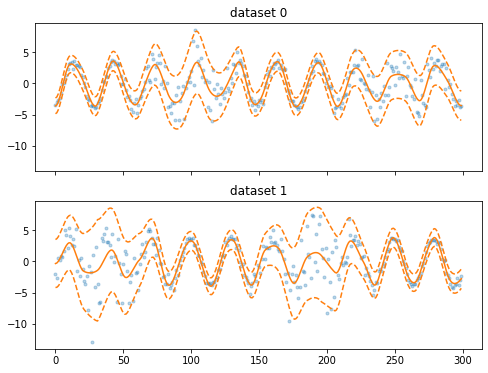

In [14]:
mus, _ = m.posterior.predict_f(Xs)

f, axes = plt.subplots(num_datasets, 1, sharex=True, sharey=True, figsize=(8, 6))
for i, (Y, ax, mu) in enumerate(zip(Ys, axes, mus)):
    ax.plot(Y, 'C0.', alpha=0.3)
    ax.plot(mu[:, 0], 'C1')
    ax.plot(mu[:, 0] + 2 * tf.exp(0.5 * mu[:, 1]), 'C1--')
    ax.plot(mu[:, 0] - 2 * tf.exp(0.5 * mu[:, 1]), 'C1--')
    ax.set_title(f'dataset {i}')